## Preamble

In [3]:
import jax, jax.numpy as jnp
import argparse
import matplotlib.pyplot as plt
import numpy as np
import dill
import math
# import os
# import matplotlib
plt.rcParams['font.size'] = 20

jax.config.update('jax_platform_name', 'gpu') # switch to 'cpu' if unavailable or depending on computation type
jax.config.update('jax_enable_x64', False)
from src.stats.hmm import get_generative_model
from src.variational import get_variational_model
from src.utils.misc import tree_get_idx, tree_dropfirst, tree_droplast
from src.training import SVITrainer
from src.stats.ula import ULA

def set_defaults(args, default_std=0.1):
    args.default_prior_mean = 0.0 # default value for the mean of Gaussian prior
    args.default_prior_base_scale = default_std # default value for the diagonal components of the covariance matrix of the prior
    args.default_transition_base_scale = default_std # default value for the diagonal components  of the covariance matrix of the transition kernel
    args.default_transition_bias = 0.0
    args.default_emission_base_scale = default_std
    args.parametrization = 'cov_chol'
    return args


def plot_x_true_against_x_pred(x_true, x_pred, y=None, save=False):
    dims = x_true.shape[-1]
    _ , axes = plt.subplots(dims, 1, figsize=(15,2*dims))
    for dim in range(dims):
        axes[dim].plot(x_true[:,dim], c='red', label='True', alpha=0.7)
        axes[dim].plot(x_pred[:,dim], c='green', label='Pred', alpha=0.7)
        axes[dim].legend()
        if y is not None:
            axes[dim].plot(y[:,dim], c='black', label='Obs', alpha=0.5)
    if save: plt.savefig('test.pdf', format='pdf')   
    
def plot_data(y):
    dims = y.shape[-1]
    _ , axes = plt.subplots(dims, 1, figsize=(15,2*dims))
    for dim in range(dims):
        axes[dim].plot(y[:,dim], label='Data')

def compute_rmse_x_true_against_x_pred(x_true, x_pred):
    return jnp.mean(jnp.sqrt(jnp.mean((x_true-x_pred)**2, axis=-1)))

## Linear-Gaussian HMM 

### Learning in an offline setting

In [ ]:
key = jax.random.PRNGKey(0) # seed
p_args = argparse.Namespace() # will contain all configuration information for the generative model 
p_args.state_dim, p_args.obs_dim = 10,10 # dimensions of state and observation spaces
p_args.model = 'linear'
p_args.seq_length = 5_00
p_args.emission_bias = False # no bias in the emission kernel, i.e. only Y_t = B X_t + noise
p_args.transition_bias = False # no bias in the transition kernel, i.e. only X_t = A X_{t-1} + noise
p_args.transition_matrix_conditionning = 'diagonal' # the transition matrix will be diagonal
p_args.range_transition_map_params = [0.8,0.97] # the diagonal values are constrained to [0.9 1]
p_args.num_seqs = 1 #
p_args = set_defaults(p_args, math.sqrt(0.1)) # setting default values for the covariances with realistic Signal to noise ratios
p = get_generative_model(p_args) # getting the model and its parameters 
# save_args(p_args, 'args', exp_path) # saving the params of the generative model
# save_params(theta, 'theta', exp_path) # saving the parameters
# jnp.save(os.path.join(exp_path, 'xs'), xs)
# jnp.save(os.path.join(exp_path, 'ys'), ys)

q_args = argparse.Namespace() # will contain all configuration information for the variational model 
q_args.state_dim, q_args.obs_dim = p_args.state_dim, p_args.obs_dim 
q_args.model = 'linear' 
q_args.emission_bias = False 
q_args.transition_bias = False 
q_args.transition_matrix_conditionning = 'diagonal' 
q_args.range_transition_map_params = [-0.9,0.9] 
q_args = set_defaults(q_args, math.sqrt(0.1)) 
# sub_exp_path = os.path.join(exp_path, q_args.model)
# os.makedirs(sub_exp_path, exist_ok=True)
# save_args(p_args, 'args', sub_exp_path) # saving the params of the generative model
q = get_variational_model(q_args) # getting the corresponding model


learning_key = jax.random.PRNGKey(0)

elbos_list = dict()
params_list = dict()
# monitored_elbo_list = dict()

num_fits = 10

generative_settings = []
key, key_generative, key_learning = jax.random.split(key, 3)

for fit_nb in range(num_fits):
    key_generative, key_theta, key_sequences = jax.random.split(key_generative, 3)
    theta = p.get_random_params(key_theta, p_args)
    xs, ys = p.sample_multiple_sequences(key_sequences, 
                                     theta, 
                                     p_args.num_seqs, 
                                     p_args.seq_length,
                                     single_split_seq=False, # not sampling a sequence and splitting into subsequences
                                     load_from='', # not loading from external folder
                                     loaded_seq=False) # not loading sequences
    generative_settings.append((theta, (xs, ys)))
    
elbo_modes = [
        'closed_form', 
        'score,monitor,resampling,bptt_depth_2']

num_epochs = 1_000
key_params, key_mc = jax.random.split(key_learning, 2)
keys_params = jax.random.split(key_params, num_fits)
keys_mc = jax.random.split(key_mc, num_fits)

for elbo_mode in elbo_modes:
    
    elbos_list[elbo_mode] = dict()
    # monitored_elbo_list[elbo_mode] = dict()
    params_list[elbo_mode] = dict()

    for fit_nb in range(num_fits):
        trainer = SVITrainer(p=p,
                            theta_star=generative_settings[fit_nb][0],
                            q=q,
                            optimizer='adam',
                            learning_rate=1e-2, 
                            optim_options='cst', # learning rate schedule
                            num_epochs=num_epochs, # number of full sweeps through the sequence
                            seq_length=p_args.seq_length,
                            num_samples=10, # number of monte carlo samples (discarded for the analytical elbo)
                            frozen_params='', # which parameters to hold fixed
                            num_seqs=p_args.num_seqs, 
                            training_mode=f'reset,{p_args.seq_length},1', 
                            elbo_mode=elbo_mode)

        fitted_variational_params, elbos, aux_results, all_params = trainer.fit(keys_params[fit_nb], 
                                                                                keys_mc[fit_nb], 
                                                                                data=generative_settings[fit_nb][1][1], 
                                                                                args=q_args)
        

        if 'score' in elbo_mode: 
            elbos_list[elbo_mode][fit_nb] = aux_results[0].squeeze().tolist()
        else:
            elbos_list[elbo_mode][fit_nb] = elbos.flatten().tolist()
        params_list[elbo_mode][fit_nb] = fitted_variational_params

In [ ]:
# with open('elbos', 'wb') as f: 
#     dill.dump(elbos_list, f)
# with open('params', 'wb') as f: 
#     dill.dump(params_list, f)

with open('elbos', 'rb') as f: 
    elbos_list = dill.load(f)
with open('params', 'rb') as f: 
    params_list = dill.load(f)

In [ ]:
elbos = np.zeros((len(elbo_modes), num_fits, num_epochs))
for i, elbo_mode in enumerate(elbo_modes):
    for j, fit_nb in enumerate(range(num_fits)):
        elbos[i,j] = elbos_list[elbo_mode][fit_nb]

elbos_mean = np.mean(elbos, axis=1)
eblos_std = np.std(elbos, axis=1)

for idx, (elbo_mode, name, color) in enumerate(zip(
                            elbo_modes, 
                            ['Analytical', 'Score'], 
                            ['black', 'red'])):

    for fit_nb in range(num_fits):
        plt.plot(elbos[idx, fit_nb], linestyle='dotted', color=color, alpha=0.2)

    plt.plot(elbos_mean[idx], 
                color=color, 
                label=name, 
                alpha=1)
    plt.fill_between(range(num_epochs), 
                elbos_mean[idx]-eblos_std[idx], 
                elbos_mean[idx]+eblos_std[idx],
                color=color, 
                alpha=0.3)

plt.xlabel('Epoch', weight='bold')
plt.ylabel('ELBO', weight='bold')
plt.autoscale(True)
plt.tight_layout()
plt.legend()
plt.savefig('training_lgm_dim_10.pdf',format='pdf')
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())
    


In [ ]:
rmse_values = dict()
for elbo_mode in elbo_modes:
    rmse_values[elbo_mode] = []
    for fit_nb in range(num_fits):
        theta, (xs, ys) = generative_settings[fit_nb]
        x_smoothed_kalman = p.smooth_seq(ys[0], theta)[0]
        x_smoothed_variational = q.smooth_seq(ys[0], params_list[elbo_mode][fit_nb])[0]
        rmse_values[elbo_mode].append(compute_rmse_x_true_against_x_pred(x_smoothed_kalman, 
                                                                         x_smoothed_variational))
        if fit_nb == 0:
            plt.close()
            plt.figure()
            print(f'Plotting {elbo_mode}')
            plot_x_true_against_x_pred(x_smoothed_kalman, x_smoothed_variational)

rmse_values_stats = {k:(jnp.mean(jnp.array(v)), 
                    jnp.std(jnp.array(v))) for k,v in rmse_values.items()}
rmse_values_stats

In [ ]:
# print(fitted_variational_params)
x_smoothed_kalman = p.smooth_seq(ys[0], theta)[0]
x_smoothed_variational = q.smooth_seq(ys[0], fitted_variational_params)[0]
plot_x_true_against_x_pred(x_smoothed_kalman, x_smoothed_variational)
# compute_rmse_x_true_against_x_pred(x_smoothed_kalman, x_smoothed_variational)

### Streaming data

In [ ]:
key = jax.random.PRNGKey(0) # seed
p_args = argparse.Namespace() # will contain all configuration information for the generative model 
p_args.state_dim, p_args.obs_dim = 10,10 # dimensions of state and observation spaces
p_args.model = 'linear'
p_args.seq_length = 500_000
p_args.emission_bias = False # no bias in the emission kernel, i.e. only Y_t = B X_t + noise
p_args.transition_bias = False # no bias in the transition kernel, i.e. only X_t = A X_{t-1} + noise
p_args.transition_matrix_conditionning = 'diagonal' # the transition matrix will be diagonal
p_args.range_transition_map_params = [0.6,0.9] # the diagonal values are constrained to [0.9 1]
p_args.num_seqs = 1 #
p_args = set_defaults(p_args, math.sqrt(0.1)) # setting default values for the covariances with realistic Signal to noise ratios
key, key_theta, key_sequences = jax.random.split(key, 3)
p,theta = get_generative_model(p_args, key_theta) # getting the model and its parameters 
xs, ys = p.sample_multiple_sequences(key_sequences, 
                                     theta, 
                                     num_seqs=1, 
                                     seq_length=p_args.seq_length,
                                     single_split_seq=False,
                                     load_from='')

q_args = argparse.Namespace() # will contain all configuration information for the variational model 
q_args.state_dim, q_args.obs_dim = p_args.state_dim, p_args.obs_dim 
q_args.model = 'linear' 
q_args.emission_bias = False 
q_args.transition_bias = False 
q_args.transition_matrix_conditionning = 'diagonal' 
q_args.range_transition_map_params = [-0.9,0.9] 
q_args = set_defaults(q_args, math.sqrt(0.1))
# sub_exp_path = os.path.join(exp_path, q_args.model)
# os.makedirs(sub_exp_path, exist_ok=True)
# save_args(p_args, 'args', sub_exp_path) # saving the params of the generative model
q = get_variational_model(q_args) # getting the corresponding model



In [ ]:
elbo_mode = 'score,resampling,bptt_depth_2'
trainer = SVITrainer(p=p,
                    theta_star=theta,
                    q=q,
                    optimizer='adam',
                    learning_rate=1e-3, 
                    optim_options='cst', # learning rate schedule
                    num_epochs=1, # number of full sweeps through the sequence
                    seq_length=p_args.seq_length,
                    num_samples=10, # number of monte carlo samples (or trajectories in the online case)
                    frozen_params='', # which parameters to hold fixed
                    num_seqs=p_args.num_seqs, 
                    training_mode=f'streaming,1,difference', # L_t - L_{t-1} / t
                    elbo_mode=elbo_mode)

key_init_params, key_montecarlo = jax.random.split(key, 2)
fitted_variational_params, elbos, aux_results, all_params = trainer.fit(key_init_params, 
                                key_montecarlo, 
                                data=ys, 
                                args=None)

In [ ]:
elbo_for_all_epochs = elbos.flatten()
# plt.plot(elbo_for_all_epochs)
# plt.xlabel('Iteration')
# plt.ylabel('ELBO')

steps = jnp.array([0, 
                   10_000, 
                   p_args.seq_length-1]) #jnp.arange(0, p_args.seq_length, p_args.seq_length // num_points)
colors = ['red', 'green', 'blue']

with open('online_500k_all_params','wb') as f: 
    dill.dump(all_params, f)

all_params_at_steps = tree_get_idx(-1, 
                          jax.tree_map(lambda x: jnp.take(x, indices=steps, axis=1), 
                                       all_params))

eval_length = 5_00
# x_true = xs[0][:eval_length]
# y = ys[0][:eval_length]
dim = 9


fig, (ax0, ax1) = plt.subplots(2,1)

ax0.plot(elbo_for_all_epochs, label='ELBO', c='black')
ax0.set_xlabel('Iteration')
ax0.set_ylabel('ELBO')
# plt.vlines(x=steps, ymin=-100, ymax=0, colors=colors)
# plt.tight_layout()
# plt.autoscale(True)


# _ , axes = plt.subplots(dims, 1, figsize=(10,1.5*dims))
key_test = jax.random.PRNGKey(5)
x_true, y = p.sample_seq(key_test, theta, seq_length=eval_length)
x_smoothed_kalman = p.smooth_seq(y, theta)[0]
ax1.plot(x_smoothed_kalman[:,dim], c='black', label='Optimal smoothing', alpha=0.7)
ax1.set_xlabel('Timestep')
ax1.set_ylabel(f'States dim x')
rmse_values = []

for idx, (step, color) in enumerate(zip(steps,colors)):
    params = tree_get_idx(idx, all_params_at_steps)
    x_smoothed_variational = q.smooth_seq(y, params)[0]
    rmse_values.append(compute_rmse_x_true_against_x_pred(x_smoothed_kalman, 
                                                          x_smoothed_variational))
    ax1.plot(x_smoothed_variational[:,dim],c=color, label=f'Step {step}', alpha=0.4)
    # ax1.legend()


plt.autoscale(True)
plt.tight_layout()

# plt.legend()
plt.savefig('training_100k_lgm.pdf', format='pdf')


# fig, (ax0, ax1) = plt.subplots(2,1)

# eval_length = 1000
# key_eval = jax.random.PRNGKey(2)
# x, y = p.sample_seq(key_eval, theta, eval_length)
# x_smoothed_kalman = p.smooth_seq(y, theta)[0]
# x_smoothed_variational = q.smooth_seq(y, fitted_variational_params)[0]
# plot_x_true_against_x_pred(x_smoothed_kalman, x_smoothed_variational)

In [ ]:
rmse_values

In [ ]:
elbo_for_all_epochs.shape

## Chaotic RNN

### Side-by-side comparison with Campbell et al.

2024-02-01 19:48:07.633104: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Loading transition matrix.
Sequences loaded.


/home/mathis/.venvs/jax/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/home/mathis/.venvs/jax/lib/python3.10/site-packages/haiku/_src/base.py:658: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


Num params: 1120
Not monitoring the ELBO.
USING SCORE ELBO.
Using truncated gradients.
Streaming on a single sequence only once.


Running for 500 iterations: 100%|██████████| 500/500 [02:16<00:00,  3.65it/s]


Filtering RMSE ours: 0.1057982
Filtering RMSE Campbell: 0.1048675
1step smoothing RMSE ours: 0.09149263
1-step smoothing RMSE Campbell: 0.09346383


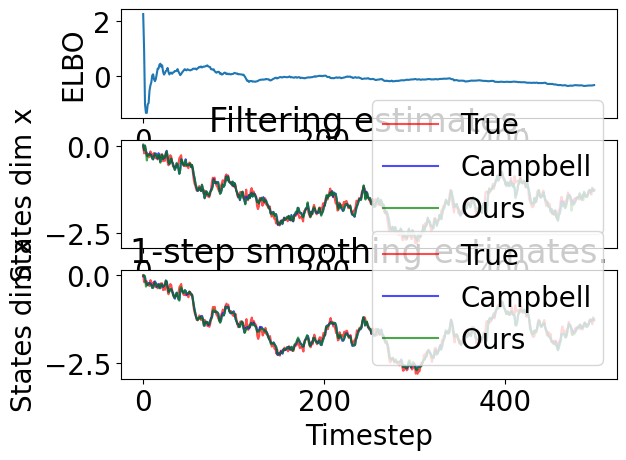

In [2]:
key = jax.random.PRNGKey(0)
key, key_params, key_sequences = jax.random.split(key, 3)
import os 
data_dirs = [os.path.join('data/crnn/dim_5_500_obs', name) for name in os.listdir('data/crnn/dim_5_500_obs')]
p_args = argparse.Namespace()
p_args.state_dim, p_args.obs_dim = 5,5
p_args.model = 'chaotic_rnn' 
p_args.seq_length = 5_00
p_args.loaded_seq = True
p_args.range_transition_map_params = [0.8,1] # range of the components of the transition matrix
p_args.transition_matrix_conditionning = 'init_scale_by_dim' # constraint
p_args.gamma = 2.5 # gamma for the chaotic rnn
p_args.tau = 0.025 # tau for the chaotic rnn
p_args.grid_size = 0.001 # discretization parameter for the chaotic rnn
p_args.emission_matrix_conditionning = 'diagonal'
p_args.range_emission_map_params = [-1,1]
p_args.default_emission_df = 2 # degrees of freedom for the emission noise
p_args.default_emission_matrix = 1.0 # diagonal values for the emission matrix
p_args.transition_bias = False 
p_args.emission_bias = False
p_args.num_seqs = 1
p_args = set_defaults(p_args, 0.1)
p_args.num_particles, p_args.num_smooth_particles = None, None

q_args = argparse.Namespace()
q_args.state_dim, q_args.obs_dim = p_args.state_dim, p_args.obs_dim 
q_args.model = 'nonamortized' # we compare to the nonamortized scenario of Campbell 
q_args.backwd_layers = (100,) # the number of neurons in the hidden layers of the NN that predicts backward parameters

q_args = set_defaults(q_args, 0.1)

q = get_variational_model(q_args)


def compute_1step_smoothing_estimates(all_params, num_samples=10_000):
    def x_tm1_t(carry, x): 
        key, filt_params_tm1, filt_params_t, backwd_params_net_t = x
        key, subkey = jax.random.split(key, 2)
        

        x_t = jax.vmap(q.filt_dist.sample, in_axes=(0, None))(jax.random.split(key, num_samples), 
                                                            filt_params_t)
        
        backwd_params_t = (backwd_params_net_t, (filt_params_tm1, filt_params_t))

        x_tm1 = jax.vmap(q.backwd_kernel.sample, in_axes=(0,0, None))(jax.random.split(subkey, 
                                                                                    num_samples), 
                                                                        x_t, 
                                                                        backwd_params_t)

        return None, jnp.mean(x_tm1, axis=0)
    
    return jax.lax.scan(x_tm1_t, 
                        init=None,
                        xs=(jax.random.split(key, p_args.seq_length-1), 
                            tree_droplast(all_params.filt),
                            tree_dropfirst(all_params.filt),
                            tree_dropfirst(all_params.backwd)))[1]

elbo_mode = 'score,resampling,truncated,bptt_depth_2'
elbo_list = []
params_list = []
key, key_init_params, key_montecarlo = jax.random.split(key, 3)

filter_means_campbell = []
smoothing_means_campbell = []
data_campbell = []
for data_dir in data_dirs[:1]: 

    p_args.load_from = data_dir
    p_args.default_transition_matrix = os.path.join(data_dir, 'W.npy')
    p, theta = get_generative_model(p_args, key_params) # no randomness here actually because we load params from Campbell et al. experiments
    xs, ys = p.sample_multiple_sequences(key_sequences, 
                                        theta, 
                                        1, 
                                        p_args.seq_length,
                                        single_split_seq=False,
                                        load_from=p_args.load_from,
                                        loaded_seq=p_args.loaded_seq)

    trainer = SVITrainer(p=p,
                        theta_star=theta,
                        q=q,
                        optimizer='adam',
                        learning_rate=1e-2, 
                        optim_options='cst', # learning rate schedule
                        num_epochs=1, # number of full sweeps through the sequence
                        seq_length=p_args.seq_length,
                        num_samples=100, # number of monte carlo samples (or trajectories in the offline case)
                        frozen_params='', # which parameters to hold fixed
                        num_seqs=p_args.num_seqs, 
                        training_mode='streaming,500', # 500 gradient steps per timestep to stabilize q_t at each t like in Campbell et al.
                        elbo_mode=elbo_mode)
    
    fitted_variational_params, elbos, aux_results, all_params = trainer.fit(key_init_params, 
                                                                            key_montecarlo, 
                                                                            data=ys, 
                                                                            args=q_args)
    


    filt_means_campbell = np.load(os.path.join(data_dir, 'filter_means.npy'))
    smoothing_means_campbell = np.load(os.path.join(data_dir, 'x_Tm1_means.npy'))

    all_params = tree_get_idx(-1, all_params)
    filt_means_ours = all_params.filt.mean
    smoothing_means_ours = compute_1step_smoothing_estimates(all_params)

    x_true = xs[0]

    fig, (ax0, ax1, ax2) = plt.subplots(3,1)
    # plt.tight_layout()
    plt.autoscale(True)

    ax0.plot(elbos[-1,:,-1], label='ELBO')
    ax0.set_xlabel('Timestep')
    ax0.set_ylabel('ELBO')
    
    dim = p_args.state_dim-1
    ax1.plot(x_true[:,dim], c='red', label='True', alpha=0.7)
    ax1.plot(filt_means_campbell[:,dim],c='blue', label='Campbell', alpha=0.7)
    ax1.plot(filt_means_ours[:,dim], c='green', label='Ours', alpha=0.7)
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel('States dim x')

    ax1.set_title('Filtering estimates.')
    ax1.legend()

    ax2.plot(x_true[:-1,dim], c='red', label='True', alpha=0.7)
    ax2.plot(smoothing_means_campbell[:,dim],c='blue', label='Campbell', alpha=0.7)
    ax2.plot(smoothing_means_ours[:,dim], c='green', label='Ours', alpha=0.7)
    ax2.set_xlabel('Timestep')
    ax2.set_ylabel('States dim x')

    ax2.set_title('1-step smoothing estimates.')
    ax2.legend()

    print('Filtering RMSE ours:', compute_rmse_x_true_against_x_pred(x_true, filt_means_ours))
    print('Filtering RMSE Campbell:', compute_rmse_x_true_against_x_pred(x_true, filt_means_campbell))

    print('1step smoothing RMSE ours:', compute_rmse_x_true_against_x_pred(x_true[:-1], smoothing_means_ours))
    print('1-step smoothing RMSE Campbell:', compute_rmse_x_true_against_x_pred(x_true[:-1], smoothing_means_campbell))

### Recursive gradients for faster convergence

In [ ]:
p_args = argparse.Namespace()
key = jax.random.PRNGKey(0)

p_args.state_dim, p_args.obs_dim = 5,5
p_args.model = 'chaotic_rnn' 
p_args.seq_length = 5_00
p_args.loaded_seq = False
p_args.load_from = '' #data/crnn/2022-10-18_15-28-00_Train_run'
p_args.range_transition_map_params = [0.6,0.9] # range of the components of the transition matrix
p_args.transition_matrix_conditionning = 'init_scale_by_dim' # constraint
p_args.default_transition_matrix = None ##os.path.join(p_args.load_from, 
                                                 # 'W.npy')

p_args.gamma = 2.5 # gamma for the chaotic rnn
p_args.tau = 0.025 # tau for the chaotic rnn
p_args.grid_size = 0.001 # discretization parameter for the chaotic rnn

p_args.emission_matrix_conditionning = 'diagonal'
p_args.range_emission_map_params = [-1,1]
p_args.default_emission_df = 2 # degrees of freedom for the emission noise
p_args.default_emission_matrix = 1.0 # diagonal values for the emission matrix
p_args.transition_bias = False 
p_args.emission_bias = False
p_args.num_seqs = 1 #

p_args = set_defaults(p_args)
p_args.num_particles, p_args.num_smooth_particles = None, None

key, key_params, key_sequences = jax.random.split(key, 3)
p, theta = get_generative_model(p_args, key_params)
xs, ys = p.sample_multiple_sequences(key_sequences, 
                                     theta, 
                                     1, 
                                     p_args.seq_length,
                                     single_split_seq=False,
                                     load_from=p_args.load_from,
                                     loaded_seq=p_args.loaded_seq)


q_args = argparse.Namespace()
q_args.model = 'johnson_backward,10'
q_args.state_dim, q_args.obs_dim = p_args.state_dim, p_args.obs_dim
q_args.transition_bias = False
q_args.emission_bias = False
layers = [int(nb) for nb in q_args.model.split(',')[-1].split('_')]
q_args.update_layers = (*layers,)
q_args.backwd_layers = 0
q_args.transition_matrix_conditionning = 'diagonal'
q_args.range_transition_map_params = (0.6, 0.9)
q_args.anisotropic = False

q_args = set_defaults(q_args)

q = get_variational_model(q_args)

num_epochs = 50
num_fits = 10

elbos_list = dict()


key, key_init_params, key_montecarlo = jax.random.split(key, 3)
keys_params = jax.random.split(key, num_fits)
keys_mc = jax.random.split(key, num_fits)
for training_mode, elbo_mode, learning_rate in zip([f'reset,{p_args.seq_length},1', 'streaming,1,difference'],
                                                    ['autodiff_on_batch', 'score,resampling,bptt_depth_2'],
                                                    [1e-3, 1e-3]):
    elbos_list[elbo_mode] = []
    
    trainer = SVITrainer(p=p,
                        theta_star=theta,
                        q=q,
                        optimizer='adam',
                        learning_rate=learning_rate, 
                        optim_options='cst', # learning rate schedule
                        num_epochs=num_epochs, # number of full sweeps through the sequence
                        seq_length=p_args.seq_length,
                        num_samples=10, # number of monte carlo samples (or trajectories in the offline case)
                        frozen_params='', # which parameters to hold fixed
                        num_seqs=p_args.num_seqs, 
                        training_mode=training_mode, # 10 gradient steps per timestep should be enough to have stabilized q_t at each t
                        elbo_mode=elbo_mode)
    for fit_nb in range(num_fits):

        fitted_variational_params, elbos, aux_results, all_params = trainer.fit(keys_params[fit_nb], 
                                        keys_mc[fit_nb], 
                                        data=ys, 
                                        args=q_args)
        
        elbos_list[elbo_mode].append(elbos)


In [ ]:
with open('elbos_faster_convergence','wb') as f:
    dill.dump(elbos_list, f)

In [ ]:
results = dict()

plt.rcParams['font.weight'] = 'normal'
plt.rcParams['font.size'] = 20

for idx, (method_name, elbo_mode) in enumerate(zip(['Backward MC', 'Score'], 
                                                   ['autodiff_on_batch', 'score,resampling,bptt_depth_2'])):
    elbo_values = jnp.array(elbos_list[elbo_mode])[:,:,-1,:]
    results[method_name] = (jnp.mean(elbo_values, axis=0).flatten(), jnp.std(elbo_values, axis=0).flatten())

for method_name in ['Backward MC', 'Score']:
    means = results[method_name][0]
    std = results[method_name][1]
    plt.plot(means, label=method_name)
    plt.fill_between(range(num_epochs), means-std, means+std, alpha=0.4)

plt.xlabel('Epoch')
plt.tight_layout()
plt.autoscale(True)
plt.ylabel('ELBO')
plt.savefig('faster_convergence.pdf',format='pdf')
plt.legend()


### Learning on streaming data

#### Training on 100k observation in 10 dimensions

In [ ]:
key = jax.random.PRNGKey(1)


p_args = argparse.Namespace()
p_args.state_dim, p_args.obs_dim = 10,10
p_args.model = 'chaotic_rnn' 
p_args.seq_length = 100_000
p_args.loaded_seq = False
p_args.load_from = '' #data/crnn/2022-10-18_15-28-00_Train_run'
p_args.range_transition_map_params = [0.8,1] # range of the components of the transition matrix
p_args.transition_matrix_conditionning = 'init_scale_by_dim' # constraint
p_args.default_transition_matrix = None ##os.path.join(p_args.load_from, 
                                                 # 'W.npy')

p_args.gamma = 2.5 # gamma for the chaotic rnn
p_args.tau = 0.025 # tau for the chaotic rnn
p_args.grid_size = 0.001 # discretization parameter for the chaotic rnn

p_args.emission_matrix_conditionning = 'diagonal'
p_args.range_emission_map_params = [-1,1]
p_args.default_emission_df = 2 # degrees of freedom for the emission noise
p_args.default_emission_matrix = 1.0 # diagonal values for the emission matrix
p_args.transition_bias = False 
p_args.emission_bias = False
p_args.num_seqs = 1 #

p_args = set_defaults(p_args)
p_args.num_particles, p_args.num_smooth_particles = None, None

key, key_params, key_sequences = jax.random.split(key, 3)
p, theta = get_generative_model(p_args, key_params)
xs, ys = p.sample_multiple_sequences(key_sequences, 
                                     theta, 
                                     1, 
                                     p_args.seq_length,
                                     single_split_seq=False,
                                     load_from=p_args.load_from,
                                     loaded_seq=p_args.loaded_seq)

q_args = argparse.Namespace()
q_args.model = 'johnson_backward,100'
q_args.state_dim, q_args.obs_dim = p_args.state_dim, p_args.obs_dim
q_args.transition_bias = False
q_args.emission_bias = False
layers = [int(nb) for nb in q_args.model.split(',')[-1].split('_')]
q_args.update_layers = (*layers,)
q_args.backwd_layers = 0
q_args.transition_matrix_conditionning = 'diagonal'
q_args.range_transition_map_params = (0.9, 1)
q_args.anisotropic = False

q_args = set_defaults(q_args)

q = get_variational_model(q_args)

for elbo_mode in ['score,resampling,bptt_depth_2']:

    trainer = SVITrainer(p=p,
                        theta_star=theta,
                        q=q,
                        optimizer='adam',
                        learning_rate=1e-3, 
                        optim_options='cst', # learning rate schedule
                        num_epochs=1, # number of full sweeps through the sequence
                        seq_length=p_args.seq_length,
                        num_samples=100, # number of monte carlo samples (or trajectories in the offline case)
                        frozen_params='', # which parameters to hold fixed
                        num_seqs=p_args.num_seqs, 
                        training_mode='streaming,1,difference', 
                        elbo_mode=elbo_mode)


    key_init_params, key_montecarlo = jax.random.split(key, 2)
    
    fitted_variational_params, elbos, aux_results, all_params = trainer.fit(key_init_params, 
                                    key_montecarlo, 
                                    data=ys, 
                                    args=q_args)
    
    elbo_for_all_epochs = elbos.flatten()

#### Visualizing smoothing performance on a subset of the data for different stages of the learning algorithm

In [ ]:
num_points = 5
# plt.rcParams.update({'font.size': 22})
#
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['font.size'] = 20

# matplotlib.rc('xtick', labelsize=20) 
# matplotlib.rc('ytick', labelsize=20) 

steps = jnp.array([0, 
                   10_000, 
                   p_args.seq_length-1]) #jnp.arange(0, p_args.seq_length, p_args.seq_length // num_points)
colors = ['red', 'green', 'blue']

all_params_at_steps = tree_get_idx(-1, 
                          jax.tree_map(lambda x: jnp.take(x, indices=steps, axis=1), 
                                       all_params))

eval_length = 5_000
# x_true = xs[0][:eval_length]
# y = ys[0][:eval_length]
dim = 9


fig, (ax0, ax1) = plt.subplots(2,1)

ax0.plot(elbo_for_all_epochs, label='ELBO', c='black')
ax0.set_xlabel('Iteration')
ax0.set_ylabel('ELBO')
# plt.vlines(x=steps, ymin=-100, ymax=0, colors=colors)
# plt.tight_layout()
# plt.autoscale(True)


# _ , axes = plt.subplots(dims, 1, figsize=(10,1.5*dims))
key_test = jax.random.PRNGKey(5)
x_true, y = p.sample_seq(key_test, theta, seq_length=eval_length)
ax1.plot(x_true[:,dim], c='black', label='True states', alpha=0.4)
ax1.set_xlabel('Timestep')
ax1.set_ylabel(f'States dim x')
rmse_values = []

for idx, (step, color) in enumerate(zip(steps,colors)):
    params = tree_get_idx(idx, all_params_at_steps)
    x_smoothed = q.smooth_seq(y, params)[0]
    rmse_values.append(compute_rmse_x_true_against_x_pred(x_true, 
                                                          x_smoothed))
    ax1.plot(x_smoothed[:,dim],c=color, label=f'Step {step}', alpha=0.7)
    # ax1.legend()


plt.autoscale(True)
plt.tight_layout()

# plt.legend()
plt.savefig('training_100k.pdf', format='pdf')